In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tushare as ts
import matplotlib as mpl
import warnings

sns.set_context('paper')


In [2]:
warnings.filterwarnings('ignore')
mpl.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif']=['SimHei']


In [3]:
def extract_data(start, end, start_datetime, end_datetime):

    ## 上证50 2020年7月-9月份数据
    close = ts.get_hist_data('sz50', start = start, end = end).sort_index()["close"]
    index_return = (close/close.shift(1)).dropna()-1
    
    ## 上证个股50每日收益
    dailyReturn = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\CNE5上证50日收益率.xlsx")
    dailyReturn.sort_values(["tradeDate", "ticker"], ascending = [1,1], inplace = True)
    dailyReturn.index = pd.to_datetime(dailyReturn["tradeDate"], format = "%Y%m%d")
    dailyReturn.drop(["secID", "exchangeCD", "secShortName", "updateTime"], axis = 1, inplace = True)
    dailyReturn.rename(columns = {"tradeDate": "Date"}, inplace = True)
    
    
    ## 组合个股权重收益
    port = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\持仓组合.xlsx", header = 2).iloc[1:,:]
    port.rename(columns = {"日收益率": "tradeDate"}, inplace = True)
    port.index = pd.to_datetime(port["tradeDate"], format = "%Y%m%d")
    port.drop(["tradeDate"], axis = 1, inplace = True)
    port = port[start_datetime:end_datetime]
    portReturn = port.iloc[:,:10]
    portWeight = port.iloc[:,14:]
    
    
    ## 上证50个股每日因子暴露
    factorExp7 = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\CNE5因子暴露表7月.xlsx").iloc[:,:-1]
    factorExp8 = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\CNE5因子暴露表8月.xlsx").iloc[:-50,:-1]
    factorExp9 = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\CNE5因子暴露表9月.xlsx").iloc[:,:-1]
    factorExp7.sort_values(['tradeDate','ticker'], ascending=[1,1],inplace = True)
    factorExp8.sort_values(['tradeDate','ticker'], ascending=[1,1],inplace = True)
    factorExp9.sort_values(['tradeDate','ticker'], ascending=[1,1],inplace = True)
    factorExp7.index = pd.to_datetime(factorExp7["tradeDate"], format = "%Y%m%d")
    factorExp8.index = pd.to_datetime(factorExp8["tradeDate"], format = "%Y%m%d")
    factorExp9.index = pd.to_datetime(factorExp9["tradeDate"], format = "%Y%m%d")
    factorExp = pd.concat([factorExp7,factorExp8,factorExp9], axis = 0)
    factor_name = [ "tradeDate",  "ticker", "secID", "exchangeCD", "secShortName","BETA", "动量", "市值", "收益率","残差波动", "成长", "账面市值比", "杠杆", "流动性","非线性市值","银行","房地产","医药生物","交通运输","采掘行业","有色金属", "家用电器", "休闲服务", "机械设备","建筑装饰", "商业贸易", "建筑材料", "汽车", "纺织服饰", "食品饮料","电子", "计算机", "轻工制造","公用事业", "通信", "农林牧渔", "化工", "传媒", "钢铁", "非银金融", "电器设备", "国防军工", "综合行业","国家" ]
    factorExp.columns = factor_name

    
    
    ## 上证50个股市值权重
    benWeight7 = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\基准上证50权重.xlsx", sheetname = "2020.7")
    benWeight8 = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\基准上证50权重.xlsx", sheetname = "2020.8")
    benWeight9 = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\基准上证50权重.xlsx", sheetname = "2020.9")
    for i in range(benWeight7.shape[0]):
        benWeight7["代码"][i] =  benWeight7["代码"][i][0:6]
        benWeight8["代码"][i] =  benWeight8["代码"][i][0:6]
        benWeight9["代码"][i] =  benWeight9["代码"][i][0:6]
    benWeight7.sort_values(["代码"], ascending = True, inplace = True)
    benWeight8.sort_values(["代码"], ascending = True, inplace = True)
    benWeight9.sort_values(["代码"], ascending = True, inplace = True)
    weight7 = benWeight7["权重"]
    weight8 = benWeight8["权重"]
    weight9 = benWeight9["权重"]
    
    ## CNE5 因子收益率
    factor_return = pd.read_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\CNE5因子收益表.xlsx", sheetname = "Tablib Dataset").iloc[:,:-1]
    factor_return.sort_values(["tradeDate"], ascending = [1], inplace = True)
    factor_return.index = pd.to_datetime(factor_return["tradeDate"], format = "%Y%m%d")
    factor_return.drop("tradeDate", axis = 1, inplace = True)
    factor_return = factor_return[start_datetime:end_datetime]
    factor_return.columns = factor_name[5:]
    
    ## 上证50个股/组合权重后的因子暴露
    ticker = portReturn.columns.tolist()    
    for j in range(len(ticker)):
        ticker[j] = ticker[j][0:6]
    portReturn.columns = ticker
    portWeight.columns = ticker

    
    
    ## 权重合并alpha_weight将组合个股权重，指数7月，8月，9月权重和超额7月，8月，9月权重合并为一个数据组，分别命名为 "port", "index7", "index8", "index9", "alpha7", "alpha8", "alpha9"
    alpha_weight = pd.DataFrame(index = ["port", "index7", "index8", "index9", "alpha7", "alpha8", "alpha9"], columns = factorExp["ticker"].unique().tolist())
    alpha_weight.loc["index7",:] = weight7.as_matrix()
    alpha_weight.loc["index8",:] = weight8.as_matrix()
    alpha_weight.loc["index9",:] = weight9.as_matrix()
    alpha_weight.loc["port",:] = 0
    

    for i in range(len(ticker)):
        alpha_weight.loc["port",int(ticker[i])] = portWeight.iloc[0,i]
    
    ## 算出组合与指数个股的7，8，9三月的个股权重差额
    alpha_weight.loc["alpha7",:] = alpha_weight.loc["port",:]- alpha_weight.loc["index7",:]
    alpha_weight.loc["alpha8",:] = alpha_weight.loc["port",:]- alpha_weight.loc["index8",:]
    alpha_weight.loc["alpha9",:] = alpha_weight.loc["port",:]- alpha_weight.loc["index9",:]
    
    ## 算出组合，指数和超额，在7，8，9三个月的行业权重
    factorExp.drop(["secID", "exchangeCD", "secShortName", "tradeDate", "ticker"], axis = 1, inplace = True)
    port_ind_weight =  alpha_weight.loc["port",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    index_ind_weight7 =  alpha_weight.loc["index7",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    alpha_ind_weight7 =  alpha_weight.loc["alpha7",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    index_ind_weight8 =  alpha_weight.loc["index8",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    alpha_ind_weight8 =  alpha_weight.loc["alpha8",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    index_ind_weight9 =  alpha_weight.loc["index9",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    alpha_ind_weight9 =  alpha_weight.loc["alpha9",:].reset_index(drop = True).dot(factorExp.iloc[:50,10:-2].reset_index(drop = True))
    
    ## 算出指数和超额，在7，8，9三个月的权重均值
    alpha_ind_weight = (alpha_ind_weight7 + alpha_ind_weight8 + alpha_ind_weight9)/3
    index_ind_weight = (index_ind_weight7 + index_ind_weight8 + index_ind_weight9)/3
    
    return index_return, factorExp, alpha_weight, factor_return, port, port_ind_weight, index_ind_weight, alpha_ind_weight
    

In [4]:


def factor_exp_contrib(index_return, factorExp, alpha_weight, factor_return, port):
    
    ## 上证50个股/组合权重后的因子暴露每日迭代
    period = len(index_return.index.unique())   
    port_factor_exposure = np.zeros([period, 39])
    index_factor_exposure7 = np.zeros([23, 39])
    alpha_factor_exposure7 = np.zeros([23, 39])
    index_factor_exposure8 = np.zeros([21, 39])
    alpha_factor_exposure8 = np.zeros([21, 39])
    index_factor_exposure9 = np.zeros([22, 39])
    alpha_factor_exposure9 = np.zeros([22, 39])
    
    ## 将7，8，9三个月的组合，指数，超额的风格因子敞口相合并

    for i in range(23):
        yest_date = factorExp.index.unique()[i]
        index_factor_exposure7[i,:] = alpha_weight.loc["index7",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
        port_factor_exposure[i,:] =alpha_weight.loc["port",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
        alpha_factor_exposure7[i,:] = alpha_weight.loc["alpha7",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
    

    for i in range(23,44):
        yest_date = factorExp.index.unique()[i]
        index_factor_exposure8[i-23,:] = alpha_weight.loc["index8",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
        port_factor_exposure[i,:] =alpha_weight.loc["port",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
        alpha_factor_exposure8[i-23,:] = alpha_weight.loc["alpha8",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))


    for i in range(44,period):
        yest_date = factorExp.index.unique()[i]
        index_factor_exposure9[i-44,:] = alpha_weight.loc["index9",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
        port_factor_exposure[i,:] =alpha_weight.loc["port",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
        alpha_factor_exposure9[i-44,:] = alpha_weight.loc["alpha9",:].reset_index(drop = True).dot(factorExp[factorExp.index == yest_date].reset_index(drop = True))
    


    index_factor_exposure = np.vstack([index_factor_exposure7, index_factor_exposure8, index_factor_exposure9])   
    alpha_factor_exposure = np.vstack([alpha_factor_exposure7, alpha_factor_exposure8, alpha_factor_exposure9])
    factor_name = factorExp.columns.tolist()

    
    index_factor_exposure = pd.DataFrame(index_factor_exposure, index = index_return.index, columns = factor_name)
    port_factor_exposure = pd.DataFrame(port_factor_exposure, index = index_return.index, columns = factor_name)
    alpha_factor_exposure = pd.DataFrame(alpha_factor_exposure, index = index_return.index, columns = factor_name)
    
    ## 将组合，指数，超额的7，8，9三个月风格因子敞口乘上对应的因子每日收益率得到对应的因子收益贡献
    index_factor_analy = index_factor_exposure*factor_return.iloc[1:,:]
    port_factor_analy = port_factor_exposure*factor_return.iloc[1:,:]
    alpha_factor_analy = alpha_factor_exposure*factor_return.iloc[1:,:]
    
    
    return index_factor_exposure, port_factor_exposure, alpha_factor_exposure, index_factor_analy, port_factor_analy, alpha_factor_analy


In [5]:
## 依据Carion模型对超额收益因子贡献由日跨度转换到月跨度进行调整
def Carino_Model(index_return, port, alpha_factor_analy, port_factor_analy,index_factor_analy):
    port_cum_ret = (port.iloc[:,10]+1).cumprod() -1
    index_cum_ret = (index_return+1).cumprod()-1
     
    kt = (np.log(np.asarray(port.iloc[:,10]+1, dtype=float)) - np.log(np.asarray(index_return+1, dtype=float)))/(port.iloc[:,10] - index_return)
    k = (np.log(1 + port_cum_ret[-1]) - np.log(index_cum_ret[-1]+1))/(port_cum_ret[-1] - index_cum_ret[-1])
    adjust = kt/k
    
    
    alpha_cum = alpha_factor_analy.mul(adjust, axis = 0).cumsum()
    port_cum = port_factor_analy.cumsum()
    index_cum = index_factor_analy.cumsum()
    return alpha_cum, port_cum, index_cum, port_cum_ret, index_cum_ret



In [6]:


## 绘图   
def plot(factor_name, factor_return, index_factor_exposure, port_factor_exposure, alpha_factor_exposure, alpha_cum, port_cum, index_cum, port_cum_ret, index_cum_ret, index_ind_weight, port_ind_weight, alpha_ind_weight):
    
    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = factor_return.iloc[:,:10].mean().sort_values().index.tolist()
    size = 10
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x,factor_return.iloc[1:,:10].mean().sort_values(),width = width, label= "平均因子收益率")
    plt.title("7-9月风格因子平均每日收益率",fontdict={'size': 12})
    plt.grid(axis="y",ls='--')
    plt.legend(prop={'size' : 12})
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = factor_return.iloc[1:,10:-1].mean().sort_values().index.tolist()
    size = 28
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x,factor_return.iloc[1:,10:-1].mean().sort_values(),width = width, label= "平均因子收益率")
    plt.title("7-9月行业因子平均每日收益率",fontdict={'size': 12})
    plt.grid(axis="y",ls='--')
    plt.legend(prop={'size' : 12})
    plt.show()


    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = index_factor_exposure.mean()[:10].index.tolist()
    size = 10
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)/3
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x+width+0.05,port_factor_exposure.mean()[:10],width = width, label= "组合因子敞口")
    plt.bar(x,index_factor_exposure.mean()[:10],width = width, label= "上证50因子敞口")
    plt.title("7-9月风格因子平均每日敞口", fontdict={'size': 12})
    plt.grid(axis="y",ls='--')
    plt.legend(prop={'size' : 12})
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = alpha_factor_exposure.mean()[:10].sort_values().index.tolist()
    size = 10
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)/3
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x+width,alpha_factor_exposure.mean()[:10].sort_values(),width = width, label= "相对因子敞口")
    plt.title("7-9月风格因子相对平均每日敞口", fontdict={'size': 12})
    plt.grid(axis="y",ls='--')
    plt.legend(prop={'size' : 12})
    plt.show()

    fig = plt.figure(figsize=(14, 6),dpi=100)
    ax1 = fig.add_subplot()
    ax1.tick_params(labelsize=15)
    labels = alpha_factor_exposure.mean()[:10].index.tolist()
    size = 10
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)/3
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    ax1.bar(x+width,alpha_factor_exposure.mean()[:10], width = width, label= "相对因子敞口")
    ax2 = ax1.twinx()
    ax2.plot(x+width,alpha_cum.iloc[-1,:10]*100, label= "超额收益因子贡献", color = "red")
    ax1.legend(loc = "upper left",prop={'size' : 15})
    ax2.legend(loc = "upper right",prop={'size' : 15})
    ax1.set_ylabel("相对因子敞口单位", size = 15)
    ax2.set_ylabel("超额收益(%)", size = 15)
    ax2.tick_params(labelsize=15)
    ax1.grid(axis="y",ls='--')
    plt.legend(prop={'size' : 15})
    plt.title("7-9月风格因子相对平均每日敞口和相对因子收益贡献", fontdict={'size': 12})
    plt.show()
    
    
    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = alpha_factor_exposure.mean()[10:-1].sort_values().index.tolist()
    size = 28
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x,alpha_factor_exposure.mean()[10:-1].sort_values(),width = width, label= "相对因子敞口")
    plt.title( "7-9月行业因子平均每日相对敞口", fontdict={'size': 12})
    plt.grid(axis="y",ls='--')
    plt.legend(prop={'size' : 12})
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = index_cum.iloc[-1,:10].index.tolist()
    size = 10
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)/2
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x,port_cum.iloc[-1,:10],width = width, label= "组合因子")
    plt.bar(x+width, index_cum.iloc[-1,:10], width = width, label = "上证50因子")
    plt.title("7-9月组合VS上证50风格因子累计贡献",fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = alpha_cum.iloc[-1,:10].sort_values().index.tolist()
    size = 10
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)
    plt.xticks(x + width/2, labels = labels, rotation = 60)
    plt.bar(x,alpha_cum.iloc[-1,:10].sort_values(), width = width, label= "超额收益因子贡献")
    plt.title("7-9月超额风格因子累计贡献",fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels =index_cum.iloc[-1,10:-1].index.tolist()
    size = 28
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)/2
    plt.xticks(x+width/2, labels = labels, rotation = 60)
    plt.bar(x,port_cum.iloc[-1,10:-1],width = width, label= "组合因子")
    plt.bar(x+width, index_cum.iloc[-1,10:-1], width = width, label = "上证50因子")
    plt.title("7-9月组合VS上证50行业因子累计贡献",fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = alpha_cum.iloc[-1,10:-1].sort_values().index.tolist()
    size = 28
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)
    plt.xticks(x + width/2, labels = labels, rotation = 60)
    plt.bar(x+width,alpha_cum.iloc[-1,10:-1].sort_values(), width = width, label= "超额收益因子贡献")
    plt.title("7-9月超额行业因子累计贡献",fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = port_ind_weight.index.tolist()
    size = 27
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)/2
    plt.xticks(x + width/2, labels = labels, rotation = 60)
    plt.bar(x,index_ind_weight, width = width, label= "上证50行业权重")
    plt.bar(x+width,port_ind_weight, width = width, label= "组合行业权重")
    plt.title("7-9月组合持仓行业权重",fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    plt.tick_params(labelsize=12)
    labels = alpha_ind_weight.sort_values().index.tolist()
    size = 27
    total_width = 0.8
    x = np.arange(size)
    width = 0.3
    x = x-(total_width - width)
    plt.xticks(x + width/2, labels = labels, rotation = 60)
    plt.bar(x,alpha_ind_weight.sort_values(), width = width, label= "相对权重")
    plt.title("7-9月组合相对行业权重",fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    labels = list(index_cum_ret.index)
    x = range(1,len(factor_return.index)*2-1,2)
    x_tick_location = np.arange(np.min(x),np.max(x),8.0)
    x_tick_labels = [labels[x.index(xi)] for xi in x_tick_location]
    plt.tick_params(labelsize=12)
    plt.xticks(x_tick_location, labels = x_tick_labels, rotation = 60)
    plt.plot(x, port_cum_ret, label = "组合累计收益")
    plt.plot(x, index_cum_ret, label = "上证50累计收益")
    plt.fill_between( x, 0, np.array(pd.to_numeric(port_cum_ret) - pd.to_numeric(index_cum_ret)) , color="blue", alpha=0.3, label = "超额累积收益")
    plt.title("7-9月 组合 VS 上证50 累计收益(%)", fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    labels = list(index_cum_ret.index)
    x = range(1,len(factor_return.index)*2-1,2)
    x_tick_location = np.arange(np.min(x),np.max(x),8.0)
    x_tick_labels = [labels[x.index(xi)] for xi in x_tick_location]
    plt.tick_params(labelsize=12)
    plt.xticks(x_tick_location, labels = x_tick_labels, rotation = 60)
    for i in range(10):
        plt.plot(x, alpha_cum.iloc[:,i], label = alpha_cum.columns.tolist()[i])
    plt.title("7-9月超额风格因子收益曲线", fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    labels = list(index_cum_ret.index)
    x = range(1,len(factor_return.index)*2-1,2)
    x_tick_location = np.arange(np.min(x),np.max(x),8.0)
    x_tick_labels = [labels[x.index(xi)] for xi in x_tick_location]
    plt.tick_params(labelsize=12)
    plt.xticks(x_tick_location, labels = x_tick_labels, rotation = 60)
    for i in range(10):
        plt.plot(x, index_cum.iloc[:,i], label = factor_name[i])
    plt.title("7-9月上阵50风格因子收益曲线", fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

    plt.figure(figsize=(11, 9),dpi=100)
    labels = list(index_cum_ret.index)
    x = range(1,len(factor_return.index)*2-1,2)
    x_tick_location = np.arange(np.min(x),np.max(x),8.0)
    x_tick_labels = [labels[x.index(xi)] for xi in x_tick_location]
    plt.tick_params(labelsize=12)
    plt.xticks(x_tick_location, labels = x_tick_labels, rotation = 60)
    for i in range(10):
        plt.plot(x, port_cum.iloc[:,i], label = factor_name[i])
    plt.title("7-9月组合风格因子收益曲线", fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    labels = list(index_cum_ret.index)
    x = range(1,len(factor_return.index)*2-1,2)
    x_tick_location = np.arange(np.min(x),np.max(x),8.0)
    x_tick_labels = [labels[x.index(xi)] for xi in x_tick_location]
    plt.tick_params(labelsize=12)
    plt.xticks(x_tick_location, labels = x_tick_labels, rotation = 60)
    for i in range(28):
        if alpha_cum.iloc[:,10+i].max() >= 0.004 or alpha_cum.iloc[:,10+i].min() <= -0.004: 
            plt.plot(x, alpha_cum.iloc[:,10+i], label = alpha_cum.columns.tolist()[10+i])
    plt.title("7-9月超额行业因子收益曲线", fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()
    
    plt.figure(figsize=(11, 9),dpi=100)
    labels = list(index_cum_ret.index)
    x = range(1,len(factor_return.index)*2-1,2)
    x_tick_location = np.arange(np.min(x),np.max(x),8.0)
    x_tick_labels = [labels[x.index(xi)] for xi in x_tick_location]
    plt.tick_params(labelsize=12)
    plt.xticks(x_tick_location, labels = x_tick_labels, rotation = 60)
    for i in range(38):
        if factor_return.columns.tolist()[i] == "银行": 
            plt.plot(x, factor_return.iloc[1:,i], label = factor_return.columns.tolist()[i])
    plt.title("7-9月行业因子收益曲线", fontdict={'size': 12})
    plt.legend(prop={'size' : 12})
    plt.grid(axis = "y", ls = "--")
    plt.show()

In [7]:
## 导出各因子收益率，组合相对因子暴露，超额因子收益贡献，组合因子贡献，上证50因子贡献表
def output_table(alpha_cum, port_cum, index_cum, port_cum_ret, index_cum_ret, alpha_factor_exposure,factor_return):
    table = pd.concat([factor_return.mean(),alpha_factor_exposure.mean(), alpha_cum, port_cum, index_cum], axis = 1)
    table.columns = ["因子收益率", "相对暴露","差额收益贡献",  "组合因子贡献", "上证50因子"]
    table.loc["基金收益"] = [0.0, 0.0, (port_cum_ret - index_cum_ret) , port_cum_ret, index_cum_ret]
    table.to_excel(r"C:\Users\wangp\OneDrive\Desktop\BARRA测试数据\7-9月因子收益表.xlsx",index=1)
    
    

In [8]:
    
## 选取数据跨度，根据数据从6月30日到9月30日 
start = "2020-06-30"
end = "2020-09-30"
start_datetime = pd.datetime(2020, 6,30)
end_datetime = pd.datetime(2020, 9,30)
  
  

index_return, factorExp, alpha_weight, factor_return, port, port_ind_weight, index_ind_weight, alpha_ind_weight  = extract_data( start,  end, start_datetime, end_datetime)
index_factor_exposure, port_factor_exposure, alpha_factor_exposure, index_factor_analy, port_factor_analy, alpha_factor_analy = factor_exp_contrib(index_return, factorExp, alpha_weight, factor_return, port)  
alpha_cum, port_cum, index_cum, port_cum_ret, index_cum_ret = Carino_Model(index_return, port, alpha_factor_analy, port_factor_analy,index_factor_analy)
factor_name = ["BETA", "动量", "市值", "收益率","残差波动", "成长", "账面市值比", "杠杆", "流动性","非线性市值","银行","房地产","医药生物","交通运输","采掘行业","有色金属", "家用电器", "休闲服务", "机械设备","建筑装饰", "商业贸易", "建筑材料", "汽车", "纺织服饰", "食品饮料","电子", "计算机", "轻工制造","公用事业", "通信", "农林牧渔", "化工", "传媒", "钢铁", "非银金融", "电器设备", "国防军工", "综合行业","国家"  ]


本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


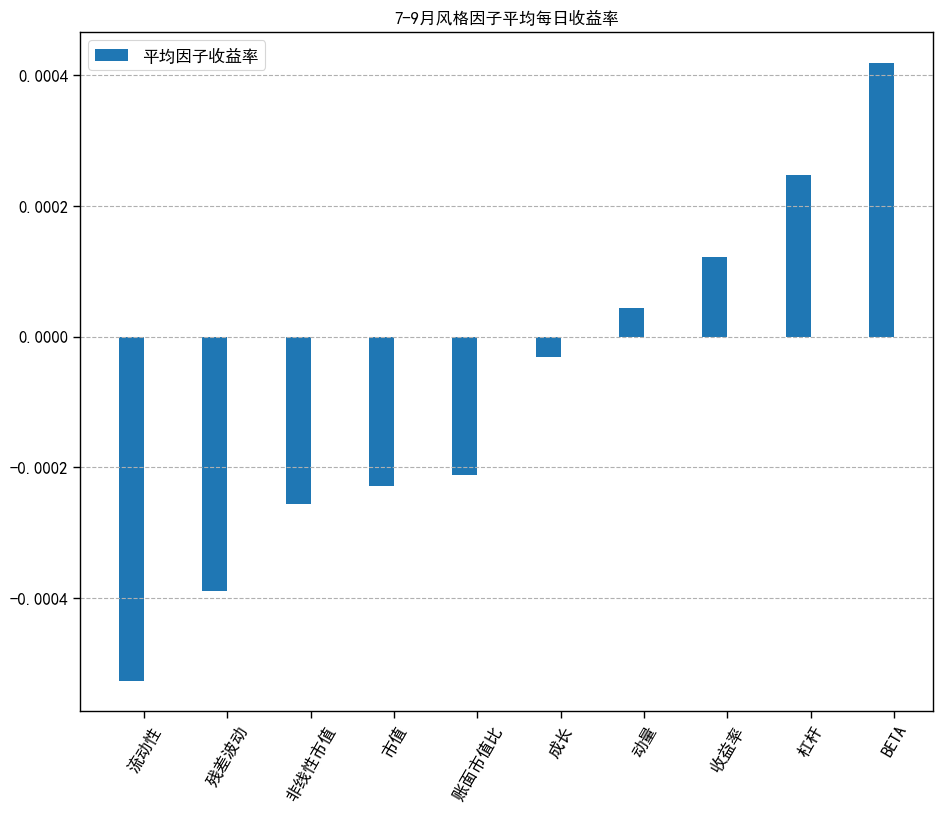

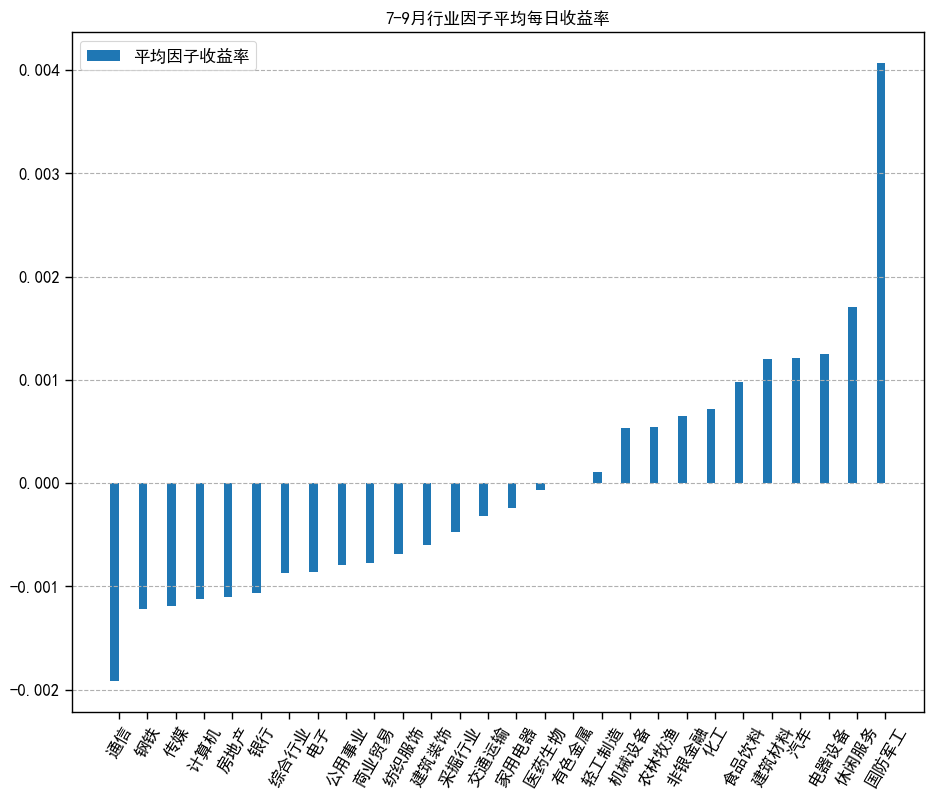

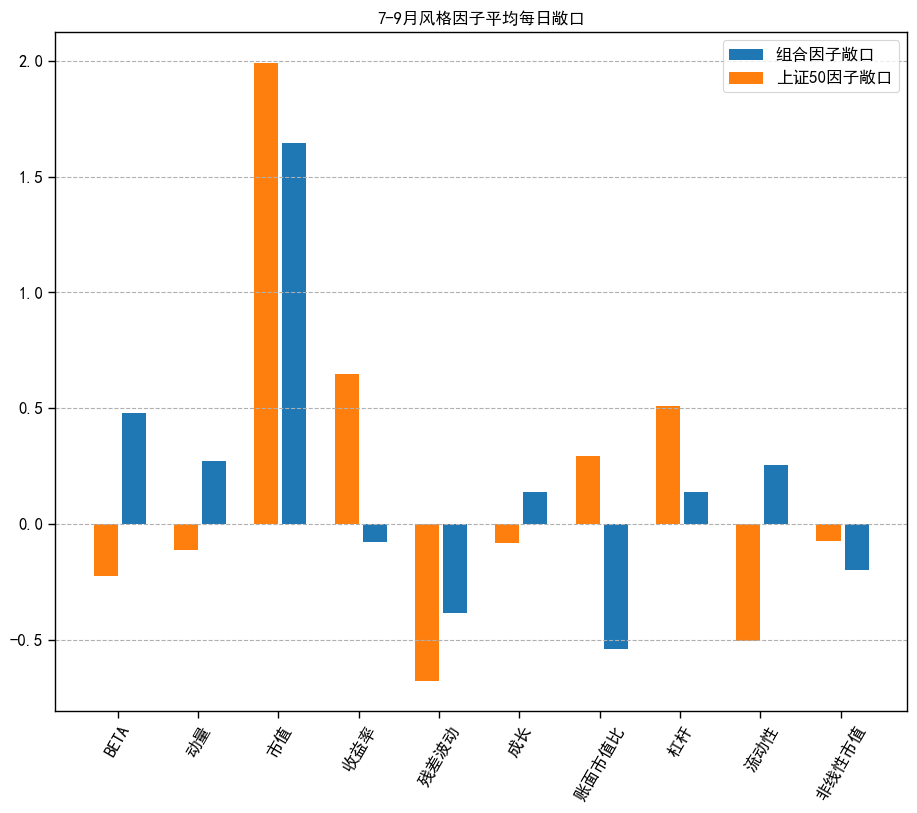

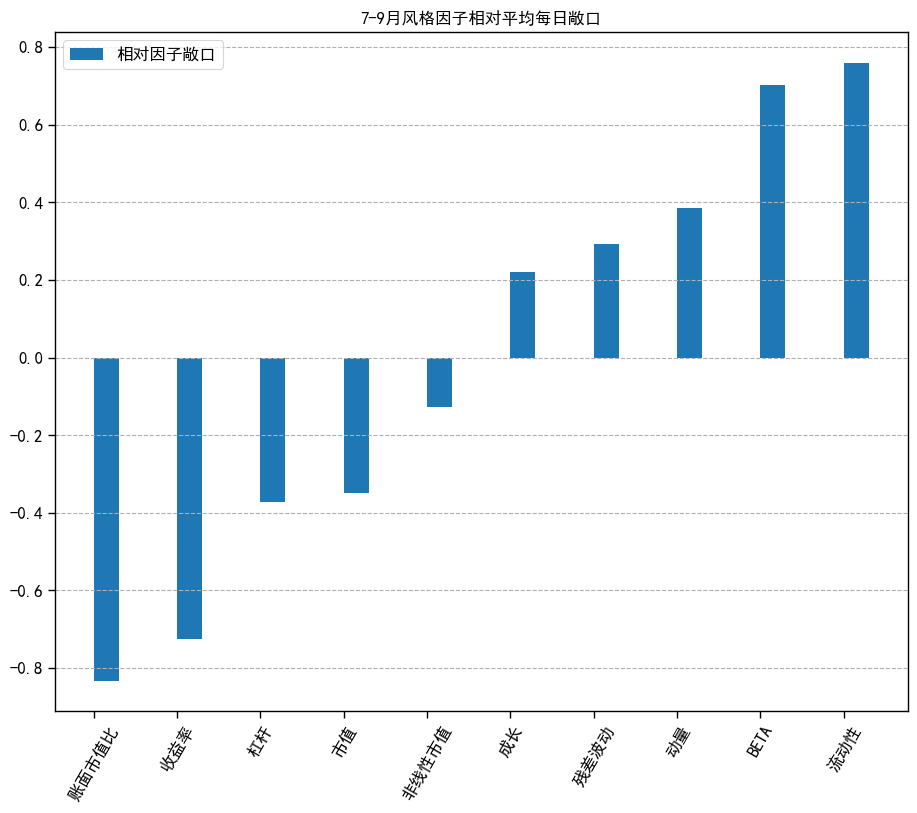

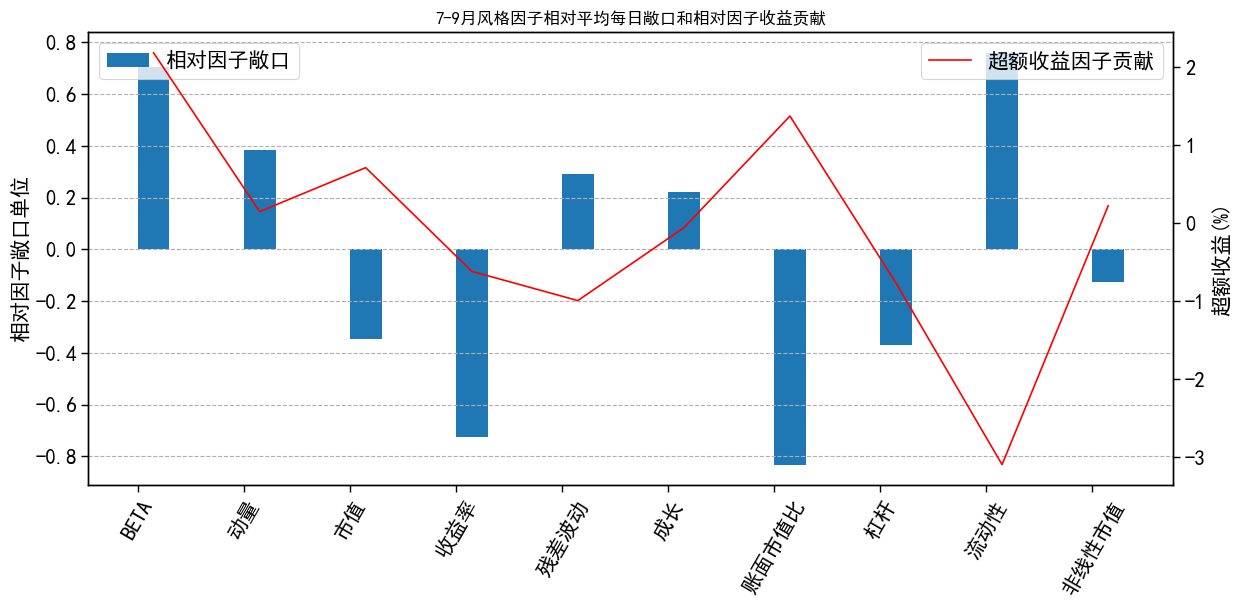

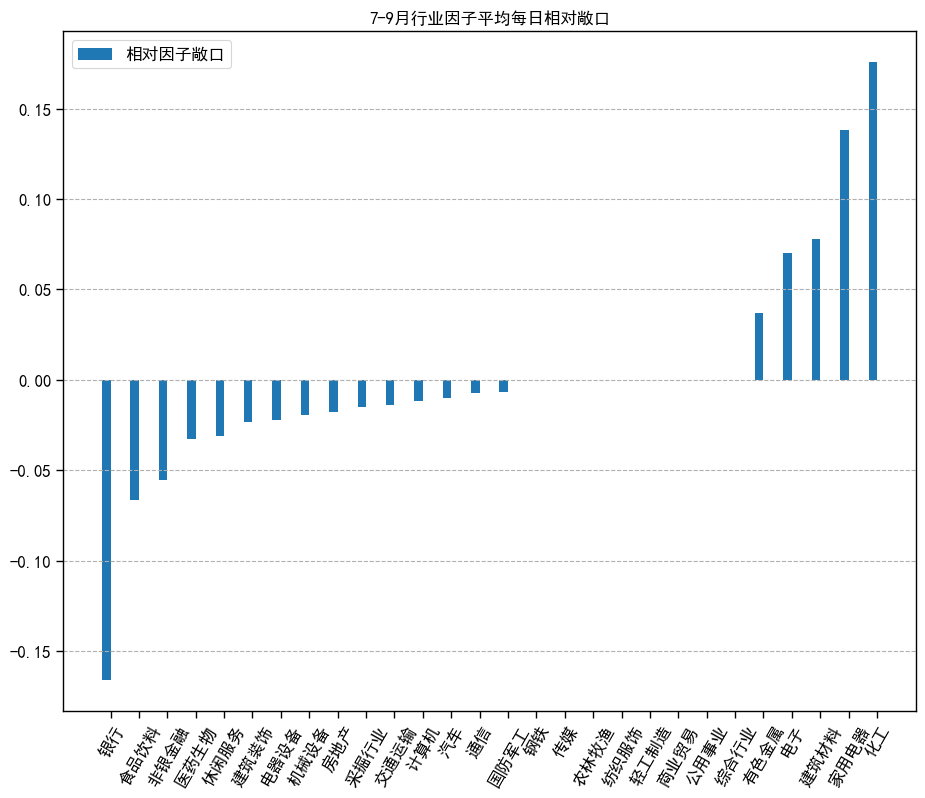

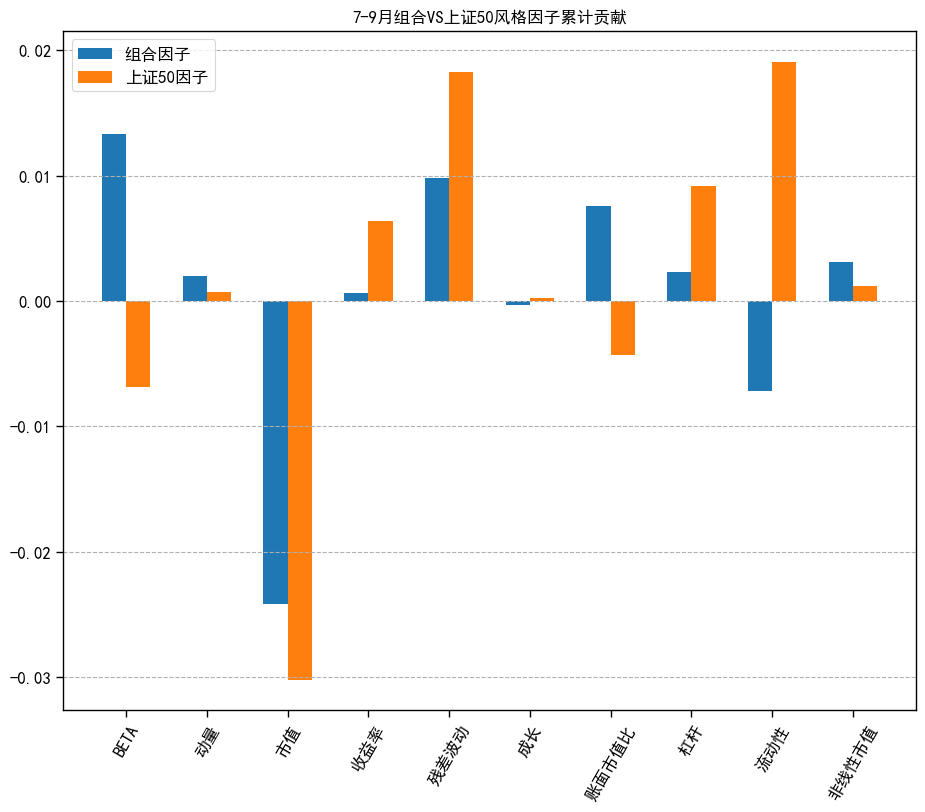

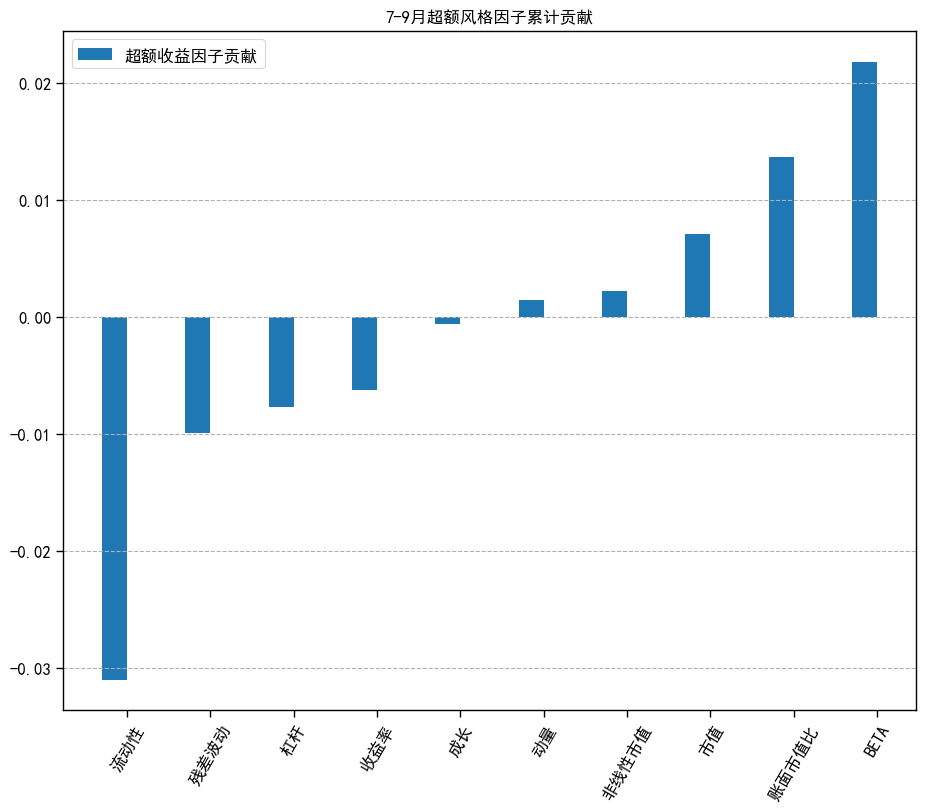

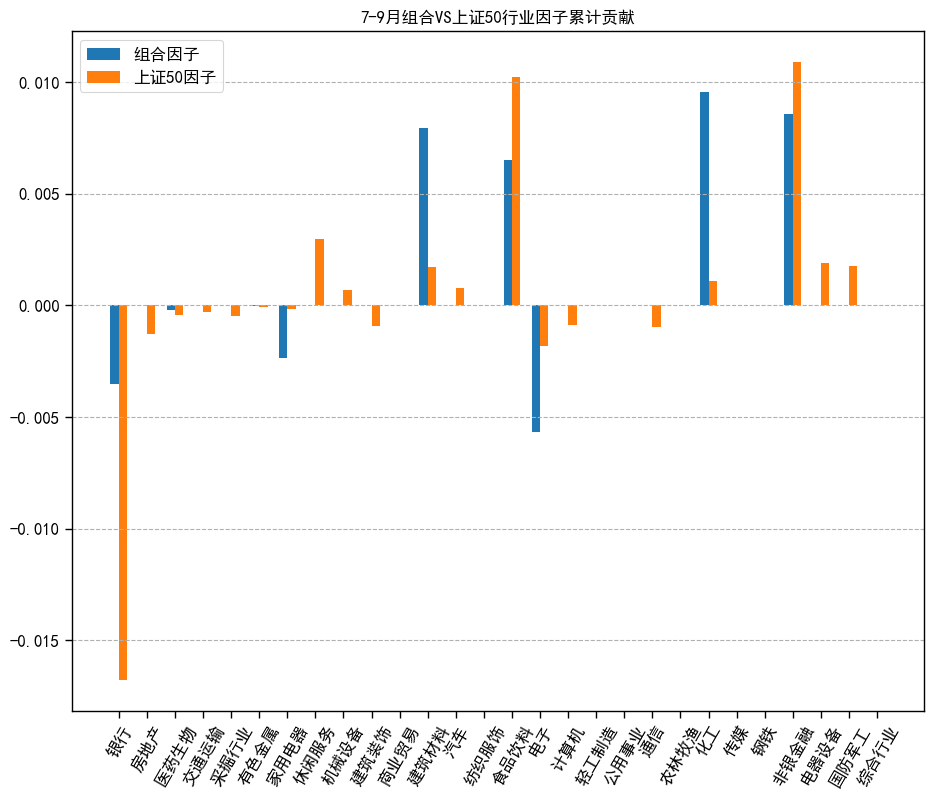

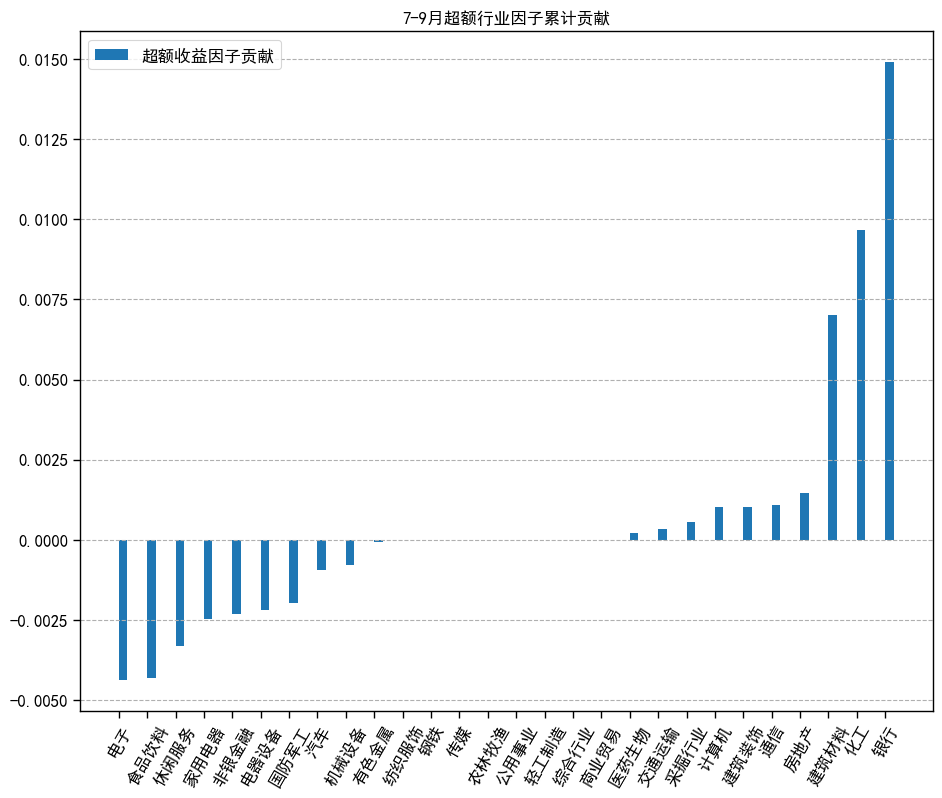

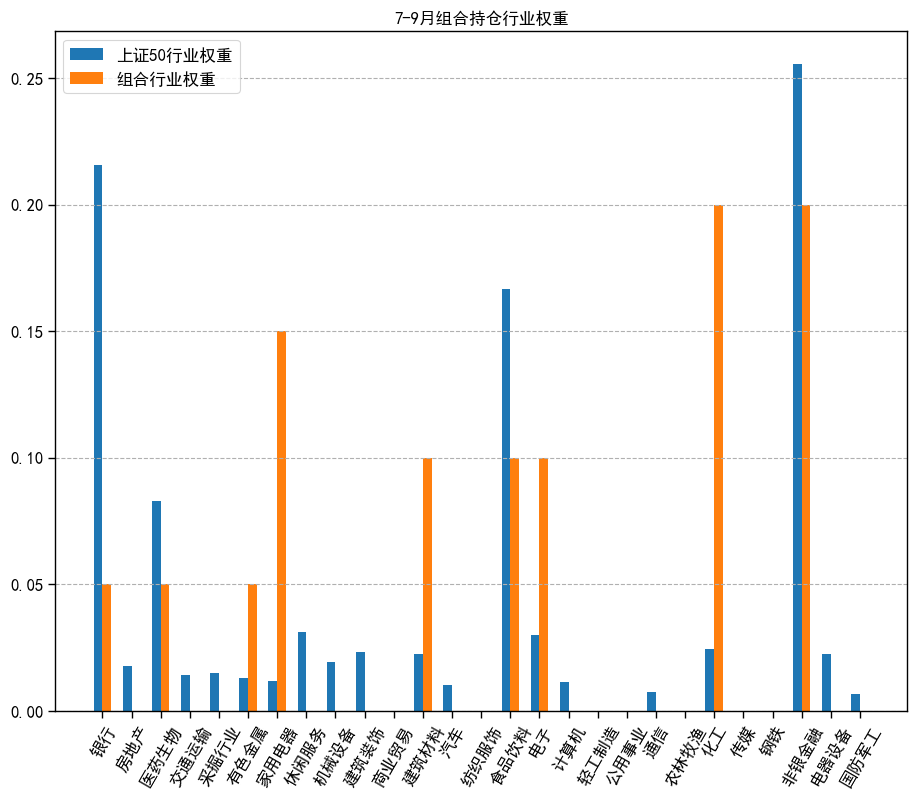

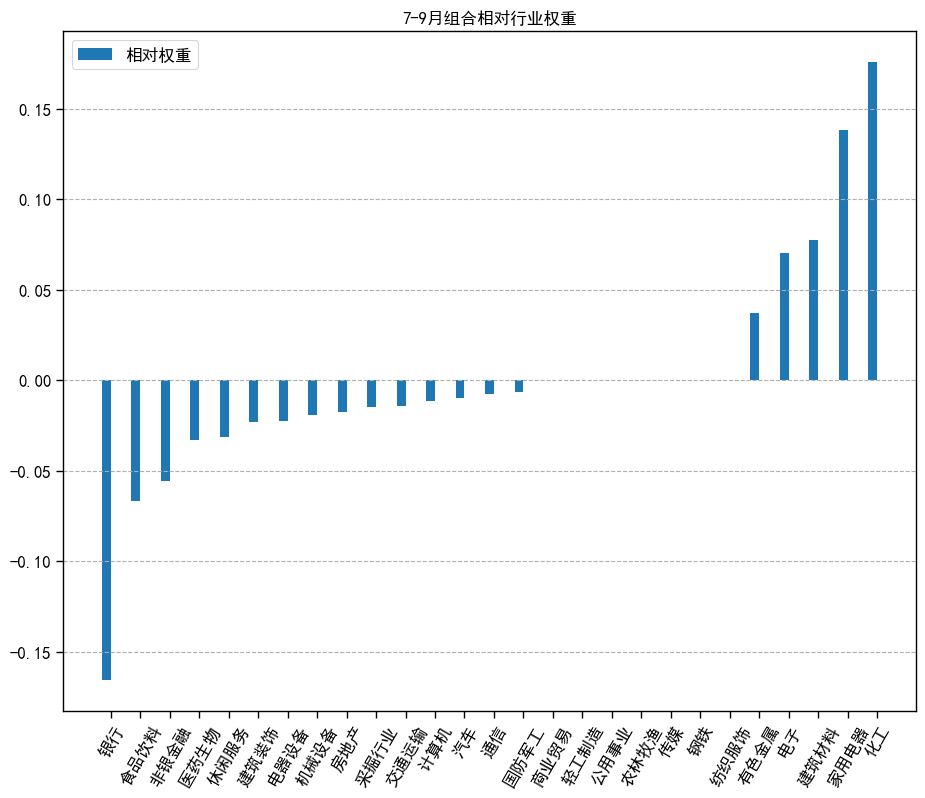

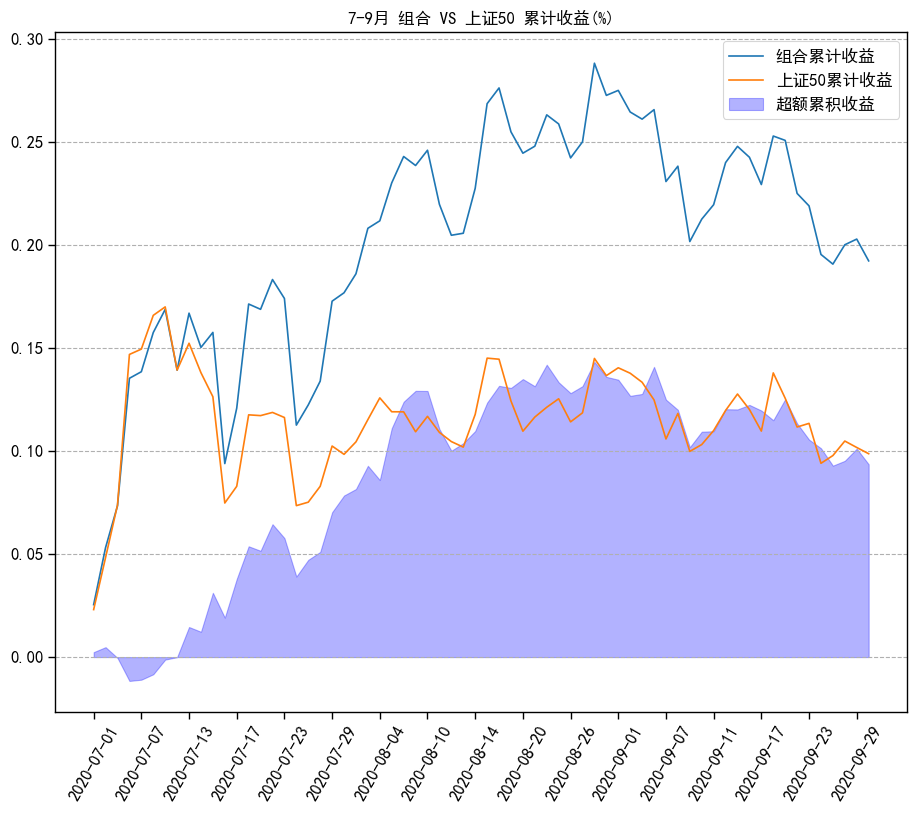

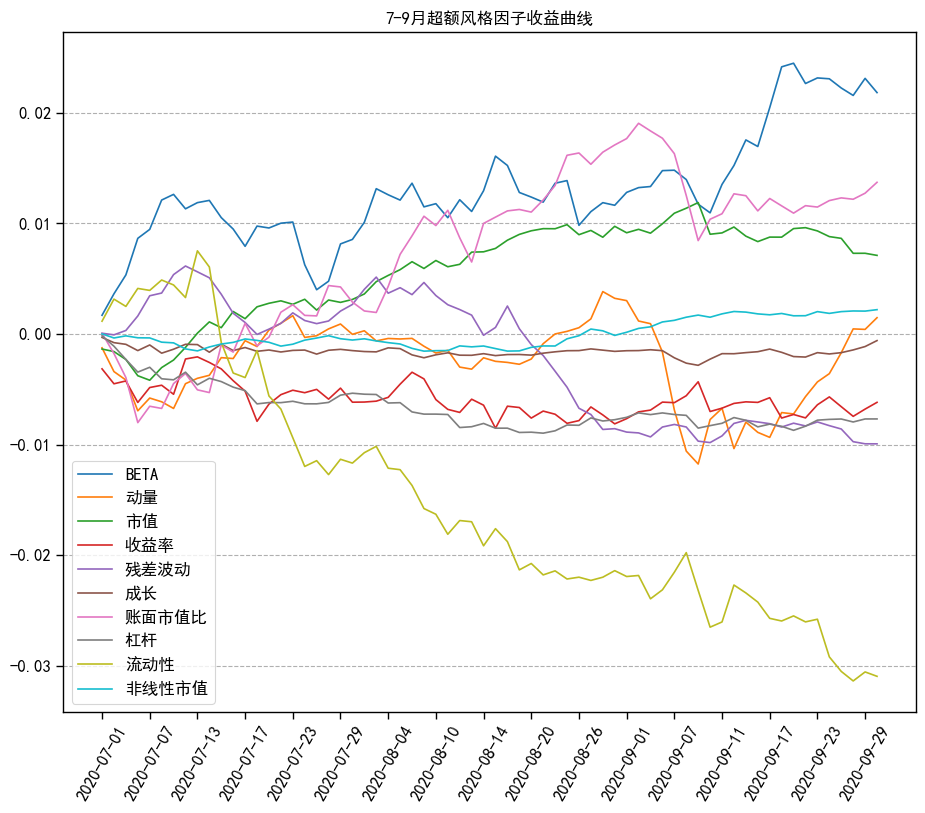

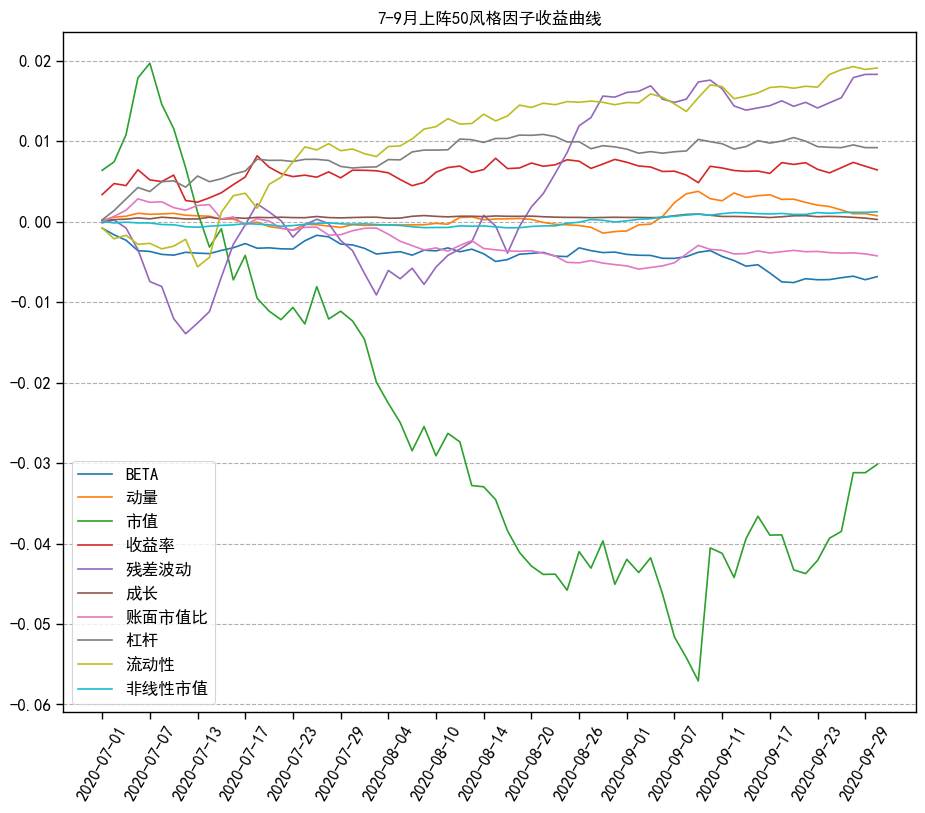

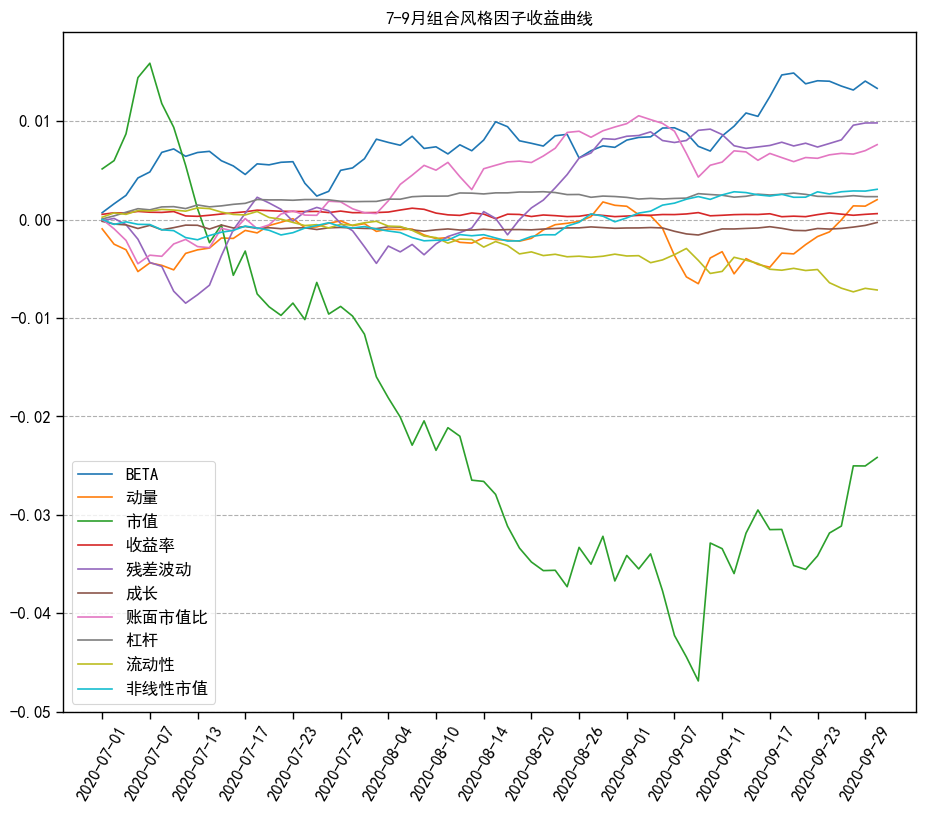

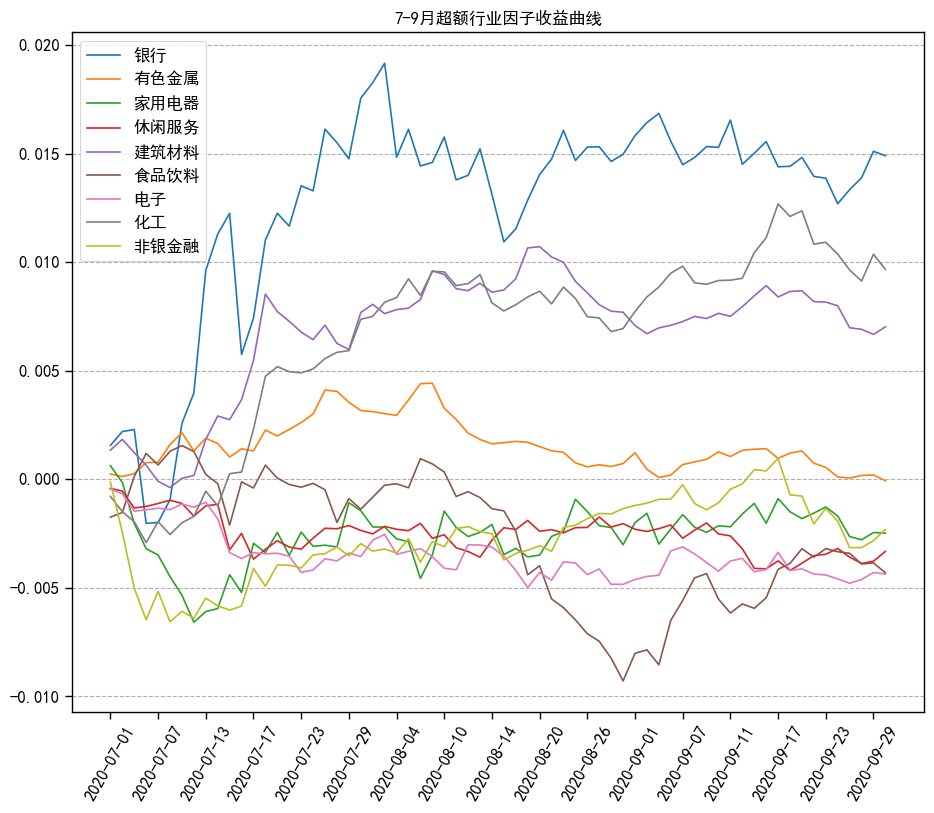

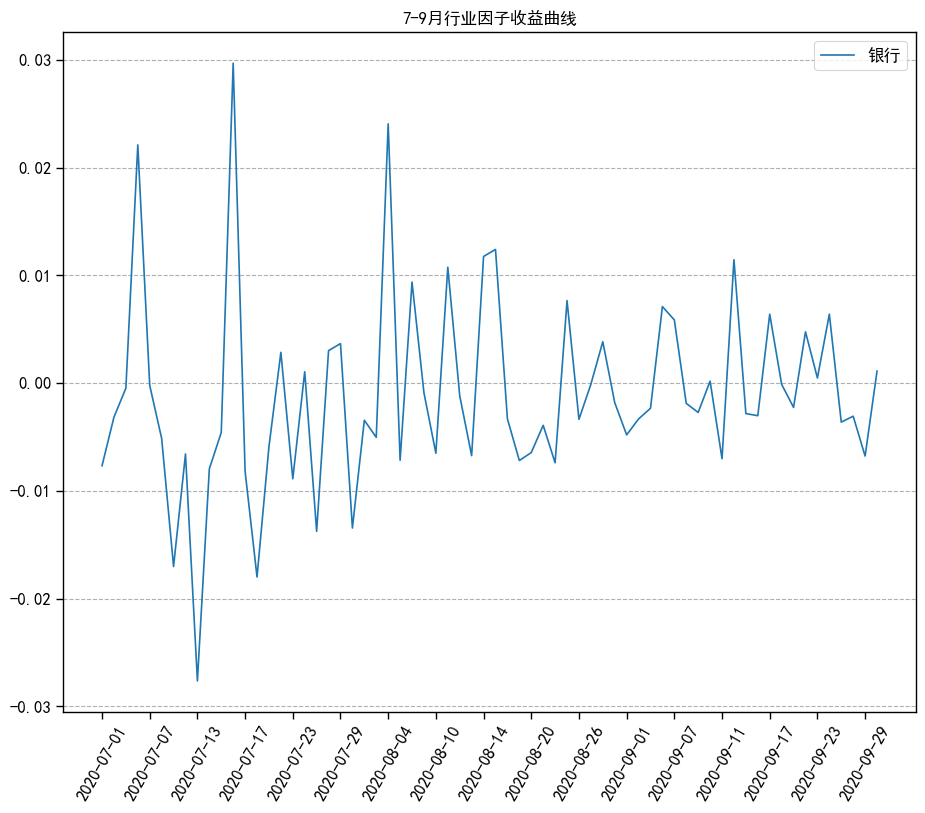

In [9]:
plot(factor_name, factor_return, index_factor_exposure, port_factor_exposure, alpha_factor_exposure, alpha_cum, port_cum, index_cum, port_cum_ret, index_cum_ret, index_ind_weight, port_ind_weight, alpha_ind_weight)

##output_table(alpha_cum.iloc[-1,:],port_cum.iloc[-1,:], index_cum.iloc[-1,:], port_cum_ret[-1], index_cum_ret[-1], alpha_factor_exposure,factor_return)
